In [1]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import itertools as iter
from random import shuffle

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))


DATA_PATH = os.getenv('DATA_PATH')
print(DATA_PATH)


2023-08-24 00:47:49.085437: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 00:47:49.595822: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1
/mnt/e/ML/MonetGAN


2023-08-24 00:47:50.588547: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-24 00:47:50.612179: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-24 00:47:50.612528: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.


## Dataset

In [2]:
allFiles=[]
for root, dirs, files in os.walk(os.path.join(DATA_PATH, "processed")):
    for f in files:
        allFiles.append(os.path.join(root, f))

In [3]:
images=[]
for i,file in enumerate(tqdm(allFiles)):
    with Image.open(file) as im:
        images.append(np.array(im))

  0%|          | 0/1884 [00:00<?, ?it/s]

In [4]:
T=200
beta = np.linspace(1e-4, 0.08, T)
alpha = 1-beta
alphaBar = [np.prod(alpha[0:i+1]) for i,el in enumerate(alpha)]
IMAGE_SIZE = [256,256]
tValues = np.arange(0,T)
# alphaBar = np.cos((tValues/(T+1) + 0.008)/(1 + 0.008) * np.pi/2) 
# np.random.shuffle(tValues)

# Make a combination of all images and all possible t values and shuffle them
trainComb = [el for el in iter.product(np.arange(0,len(images)), tValues)]
shuffle(trainComb)
dataSize = len(trainComb)


def forwardStep(x0,t):
    noise = np.random.normal(0, 1, x0.shape)
    noisy = np.sqrt(alphaBar[t])*x0 + np.sqrt(1-alphaBar[t])*noise
    return noise, noisy

def generator():
    for fileIdx,tValue in trainComb:
        # image = tf.io.read_file(file)
        # image = tf.io.decode_jpeg(image, channels=3)
        image = tf.convert_to_tensor(images[fileIdx])
        image = tf.image.random_brightness(image, 0.1)
        image = tf.image.random_contrast(image, 0.95, 1.05)
        image = (tf.cast(image, tf.float32) / 127.5) - 1
        x0 = image.numpy()
        noise, noisy = forwardStep(x0, tValue)
        yield noisy, noise, [tValue]

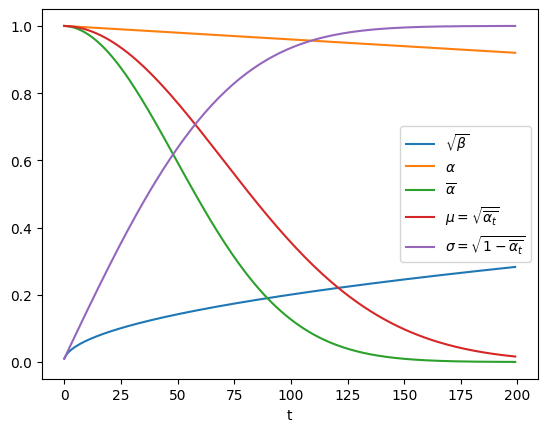

In [5]:
# _ = plt.plot(beta, label="beta")
_ = plt.plot(np.sqrt(beta), label=r"$\sqrt{\beta}$")
_ = plt.plot(alpha, label=r"$\alpha$")
_ = plt.plot(alphaBar, label=r"$\overline{\alpha}$")
_ = plt.plot(np.sqrt(alphaBar), label=r"$\mu = \sqrt{ \overline{\alpha_t} }$")
_ = plt.plot(np.sqrt(1-np.array(alphaBar)[np.arange(0,T)]), label=r"$\sigma = \sqrt{ 1-\overline{\alpha_t} }$")
_ = plt.legend()
_ = plt.xlabel("t")

In [6]:
g = generator()
test = next(g)
print(test[2])
print(test[0].shape)
print(test[1].shape)

[197]
(256, 256, 3)
(256, 256, 3)


2023-08-24 00:47:55.574656: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-24 00:47:55.575031: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-24 00:47:55.575354: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-24 00:47:56.016454: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-24 00:47:56.016805: I tensorflow/compile

In [7]:
test = next(g)
np.max(test[0])

4.021314582352734

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[122]


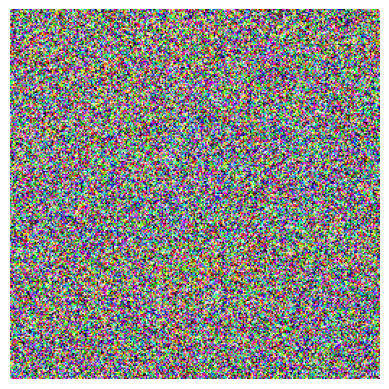

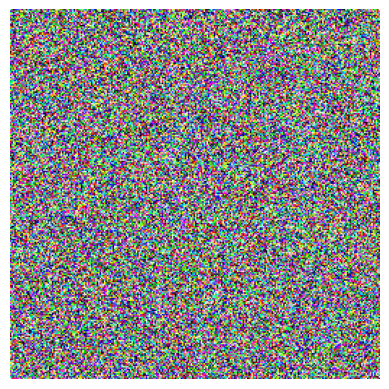

In [8]:
test = next(g)
plt.imshow((test[0]+1)/2)
plt.axis('off')
plt.figure()
plt.imshow((test[1]+1)/2)
plt.axis('off')
print(test[2])

## Testing of the forward and backward process

Test the denoising steps all at one (what the neural network should predict gradually)

(-0.5, 255.5, 255.5, -0.5)

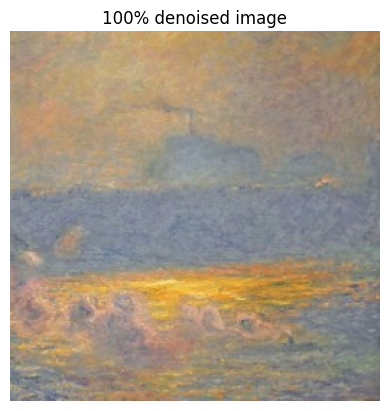

In [9]:
testDenoised = (test[0] - np.sqrt(1-alphaBar[test[2][0]])*test[1])/np.sqrt(alphaBar[test[2][0]])
plt.imshow((testDenoised+1)/2)
plt.title("100% denoised image")
plt.axis('off')

Forward pass

In [10]:
noisyImages=[]
noises=[]
x0=images[0]/127.5-1
for tStep in range(T):
    noise, noisy = forwardStep(x0, tStep)
    noisyImages.append(noisy)
    noises.append(noise)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


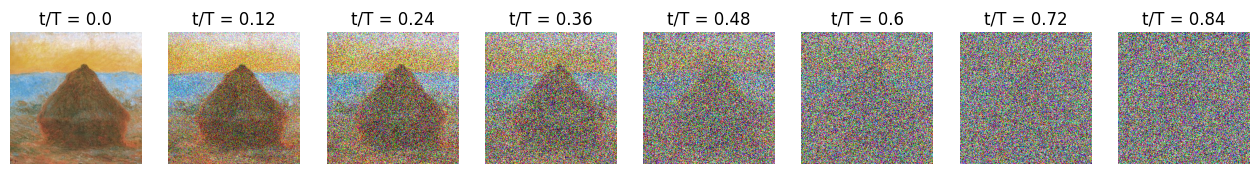

In [11]:
plt.figure(figsize=(16,5))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(noisyImages[i*24]/2+0.5)
    plt.axis("off")
    plt.title("t/T = "+str(i*24/T))

Backward pass

In [12]:
samples = [noisyImages[-1]]
predNoises = [noises[-1]]

def backwardStep(xt, predNoise, t):

    x0Pred=(xt - np.sqrt(1-alphaBar[t])*predNoise)/np.sqrt(alphaBar[t])

    if t==0:
        sample = x0Pred
        noise= np.zeros(xt.shape)
    else:
        # estimate mean
        meanPred= x0Pred * (np.sqrt(alphaBar[t])*beta[t])/((1-alphaBar[t])*np.sqrt(alpha[t])) + xt*(alpha[t]-alphaBar[t])/((1-alphaBar[t])*np.sqrt(alpha[t]))

        # compute variance
        betaPred = np.sqrt(beta[t])

        sample = meanPred + betaPred*np.random.normal(0,1,xt.shape)

        noise=(sample-x0Pred*np.sqrt(alphaBar[t-1]))/np.sqrt(1-alphaBar[t-1])

    return sample, noise

for t in np.arange(0,T)[::-1]:
    predNoise = predNoises[-1]
    xt = samples[-1]

    sample, noise = backwardStep(xt, predNoise, t)

    samples.append(sample)
    predNoises.append(noise)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


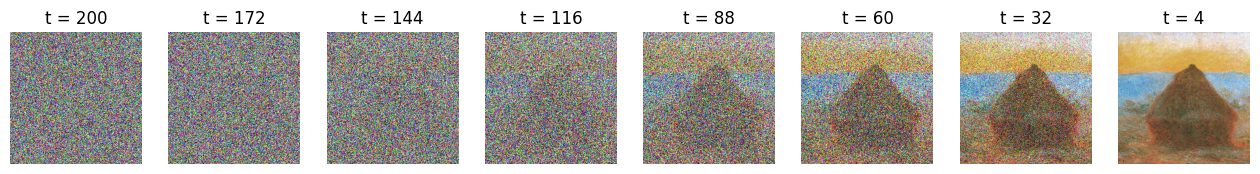

In [13]:
plt.figure(figsize=(16,5))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(samples[i*28]/2+0.5)
    plt.axis("off")
    plt.title("t = "+str(T-i*28))

In [14]:
dataset = tf.data.Dataset.from_generator(generator, output_signature=(tf.TensorSpec(shape=(*IMAGE_SIZE, 3), dtype=tf.float32),
                            tf.TensorSpec(shape=(*IMAGE_SIZE, 3), dtype=tf.float32),
                            tf.TensorSpec(shape=(1), dtype=tf.int32)))
# list(dataset.take(1))[0]

## Tensorflow

In [106]:
%load_ext tensorboard


In [15]:

def createSimpleUnet():
    inputs = tf.keras.Input(shape=(*IMAGE_SIZE, 3))
    #256

    stepInput = tf.keras.Input(shape=(1,), dtype=tf.int32)
    embeddedStep = tf.keras.layers.Embedding(T, 256)(stepInput)
    stepMap = tf.repeat(embeddedStep, 256, axis=0)
    stepMap = tf.reshape(stepMap, (-1,*IMAGE_SIZE, 1))

    concatInput = tf.keras.layers.Concatenate()([inputs, stepMap])

    xDown1In = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu" )(concatInput)
    xDown1 = tf.keras.layers.Conv2D(32, 3, padding="same", strides=2, activation="relu"  )(xDown1In)
    xDown1 = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"  )(xDown1)
    #128
    
    xDown2 = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu" )(xDown1)
    xDown2 = tf.keras.layers.Conv2D(64, 3, padding="same", strides=2, activation="relu")(xDown2)
    xDown2 = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu" )(xDown2)
    #64

    xDown3 = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu" )(xDown2)
    xDown3 = tf.keras.layers.Conv2D(128, 3, padding="same", strides=2, activation="relu"  )(xDown3)
    xDown3 = tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu"  )(xDown3)
    #32

    xDown4 = tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu" )(xDown3)
    xDown4 = tf.keras.layers.Conv2D(256, 3, padding="same", strides=2, activation="relu" )(xDown4)
    xDown4 = tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu" )(xDown4)
    #16

    xCenter = tf.keras.layers.Conv2D(256, 3, padding="same" )(xDown4)

    stepMap16 = tf.keras.layers.Conv2D(3, 3, strides=16, padding="same")(stepMap)
    concatCenter = tf.keras.layers.Concatenate()([xCenter, stepMap16])

    xCenter = tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu")(concatCenter)
    #16x16

    xUp4 = tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu")(xCenter)
    xConcat4 = tf.keras.layers.Concatenate()([xUp4, xDown4])
    xUp4 = tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu" )(xConcat4)
    xUp4 = tf.keras.layers.Conv2DTranspose(128, 3, padding="same", strides=2, activation="relu")(xUp4)
    xUp4 = tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu" )(xUp4)
    #32x32

    xUp3 = tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu")(xUp4)
    xConcat3 = tf.keras.layers.Concatenate()([xUp3, xDown3])
    xUp3 = tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu" )(xConcat3)
    xUp3 = tf.keras.layers.Conv2DTranspose(64, 3, padding="same", strides=2, activation="relu")(xUp3)
    xUp3 = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu" )(xUp3)
    #64x64

    xUp2 = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(xUp3)
    xConcat2 = tf.keras.layers.Concatenate()([xUp2, xDown2])
    xUp2 = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu" )(xConcat2)
    xUp2 = tf.keras.layers.Conv2DTranspose(32, 3, padding="same", strides=2, activation="relu")(xUp2)
    xUp2 = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu" )(xUp2)
    #128x128

    xUp1 = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu")(xUp2)
    xConcat1 = tf.keras.layers.Concatenate()([xUp1, xDown1])
    xUp1 = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu" )(xConcat1)
    xUp1 = tf.keras.layers.Conv2DTranspose(16, 3, padding="same", strides=2, activation="relu")(xUp1)
    xUp1 = tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu" )(xUp1)
    #256x256

    xConcat = tf.keras.layers.Concatenate()([xUp1, xDown1In])
    x = tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu" )(xConcat)
    
    x=tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu")(xUp1)

    outputs=tf.keras.layers.Conv2D(3, 1, padding="same")(x)

    return tf.keras.Model(inputs=[inputs,stepInput], outputs=outputs, name="SimpleUnet")


# model = createSimpleUnet()

# model.summary()

# dot_img_file = './'+model.name +'.png'
# tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)


Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 256)               51200     ['input_4[0][0]']             
                                                                                                  
 tf.repeat_1 (TFOpLambda)    (None, 1, 256)               0         ['embedding_1[0][0]']         
                                                                                                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                               

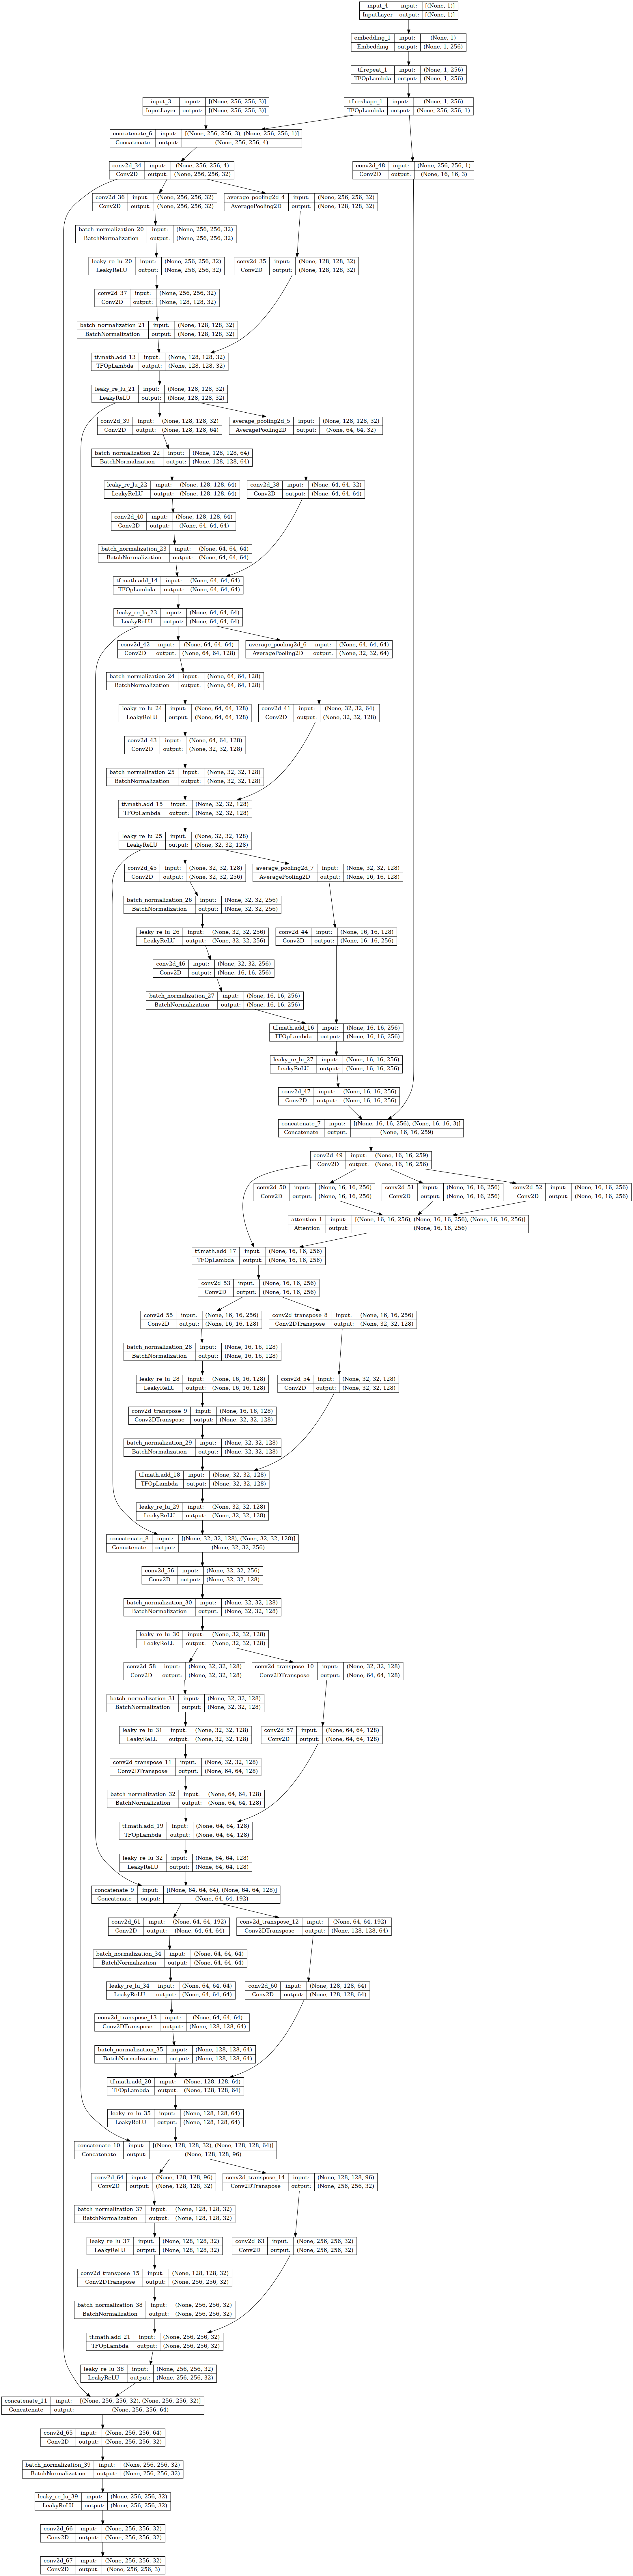

In [17]:
L2=0.0

def downscaleBlock(xIn, ch, filtersize):
    xRes = tf.keras.layers.AveragePooling2D((3,3), strides=2, padding="same")(xIn)
    xRes = tf.keras.layers.Conv2D(ch, 1,  padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xRes)

    x = tf.keras.layers.Conv2D(ch, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xIn)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.LeakyReLU()(x)
    # x = tf.keras.layers.Conv2D(ch, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)
    
    x = tf.keras.layers.Conv2D(ch, filtersize, padding="same", strides=2, kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    added = tf.math.add(x, xRes)
    x = tf.keras.layers.LeakyReLU()(added)
    
    return x


def upscaleBlock(xIn, ch, filtersize):
    # xRes = tf.keras.layers.UpSampling2D(size=(2, 2))(xIn)
    xRes = tf.keras.layers.Conv2DTranspose(ch, filtersize, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xIn)
    xRes = tf.keras.layers.Conv2D(ch, 1, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=0.01))(xRes)

    x = tf.keras.layers.Conv2D(ch, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xIn)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.LeakyReLU()(x)
    # x = tf.keras.layers.Conv2D(ch, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)
    
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2DTranspose(ch, filtersize, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    added = tf.math.add(x, xRes)
    x = tf.keras.layers.LeakyReLU()(added)

    return x


def nonLocalBlock(xIn, ch, filtersize=1):
    theta = tf.keras.layers.Conv2D(ch, filtersize, padding="same")(xIn)
    phi = tf.keras.layers.Conv2D(ch, filtersize, padding="same")(xIn)
    g = tf.keras.layers.Conv2D(ch, filtersize, padding="same")(xIn)
    out = tf.keras.layers.Attention()([theta, phi, g])
    return tf.math.add(xIn, out)

def createUnet():
    inputs = tf.keras.Input(shape=(*IMAGE_SIZE, 3))
    #256

    stepInput = tf.keras.Input(shape=(1,), dtype=tf.int32)
    embeddedStep = tf.keras.layers.Embedding(T, 256)(stepInput)
    stepMap = tf.repeat(embeddedStep, 256, axis=0)
    stepMap = tf.reshape(stepMap, (-1,*IMAGE_SIZE, 1))

    concatInput = tf.keras.layers.Concatenate()([inputs, stepMap])

    xDown2 = tf.keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(concatInput)
    
    xDown4 = downscaleBlock(xDown2, 32, 3)
    #128

    xDown8 = downscaleBlock(xDown4, 64, 3)
    #64

    xDown16 = downscaleBlock(xDown8 ,128, 3)
    #32

    xDown32 = downscaleBlock(xDown16 ,256, 3)
    #16x16

    xCenter = tf.keras.layers.Conv2D(256, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown32)

    stepMap16 = tf.keras.layers.Conv2D(3, 3, strides=16, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(stepMap)
    concatCenter = tf.keras.layers.Concatenate()([xCenter, stepMap16])

    xCenter = tf.keras.layers.Conv2D(256, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(concatCenter)
    xCenter = nonLocalBlock(xCenter, 256)
    xCenter = tf.keras.layers.Conv2D(256, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xCenter)
    #16x16

    xUp16 = upscaleBlock(xCenter, 128, 3)
    #32x32
    xConcat16 = tf.keras.layers.Concatenate()([xUp16, xDown16])
    xUp16=tf.keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xConcat16)
    xUp16 = tf.keras.layers.BatchNormalization()(xUp16)
    xUp16 = tf.keras.layers.LeakyReLU()(xUp16)

    xUp8 = upscaleBlock(xUp16, 128, 3)
    #64
    xConcat8 = tf.keras.layers.Concatenate()([xDown8, xUp8])
    xUp8=tf.keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xConcat8)
    xUp8 = tf.keras.layers.BatchNormalization()(xUp8)
    xUp8 = tf.keras.layers.LeakyReLU()(xUp8)

    xUp4 = upscaleBlock(xConcat8, 64, 3)
    #128
    xConcat4 = tf.keras.layers.Concatenate()([xDown4, xUp4])
    xUp4=tf.keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xConcat4)
    xUp4 = tf.keras.layers.BatchNormalization()(xUp4)
    xUp4 = tf.keras.layers.LeakyReLU()(xUp4)

    xUp2 = upscaleBlock(xConcat4, 32, 3)
    #256
    xConcat2 = tf.keras.layers.Concatenate()([xDown2, xUp2])
    
    x=tf.keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xConcat2)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x=tf.keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    outputs=tf.keras.layers.Conv2D(3, 1, padding="same")(x)

    return tf.keras.Model(inputs=[inputs,stepInput], outputs=outputs, name="unet")


model = createUnet()

model.summary()

dot_img_file = './'+model.name +'.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)


In [18]:
loadExistingModel=False

if loadExistingModel:
    model = tf.keras.models.load_model(os.path.join(DATA_PATH, "diffusionModel_epoch_4"))

In [19]:
def saveImages(model, epoch, step):
  initInput = tf.random.normal((2, *IMAGE_SIZE, 3), dtype=tf.float32)
  samples = [initInput]

  for t in np.arange(0,T)[::-1]:
      predNoise = model((samples[-1], tf.constant([t,t])), training=False)
      xt = samples[-1]
      
      sample, noise = backwardStep(xt, predNoise, t)

      samples.append(sample)

  _ = plt.figure(figsize=(12,5))

  sampleIdx = np.linspace(0, T, 5)

  for j in range(2):
    for i in range(5):
        _ = plt.subplot(2, 5, j*5+i+1)
        plt.imshow(np.clip((samples[int(sampleIdx[i])].numpy()[j,:,:,:]+1)/2, 0, 1))
        plt.axis("off")
        plt.title("Step {}".format(T-int(sampleIdx[i])))

  plt.savefig(os.path.join(DATA_PATH,"trainImagesDiffusion", 'epoch_{:04d}_step_{:04d}.png'.format(epoch, step)))
  plt.close()

In [20]:

BATCH_SIZE=32
LOG_INTERVAL=20
SAVE_IMAGE_INTERVAL=200
epochs = 10
saveModel=True

startEpoch=0


log_dir = "./logs/"+model.name+"/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,
                                                      write_graph=True, update_freq=5)


summary_writer = tf.summary.create_file_writer(log_dir)

# Instantiate an optimizer .
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
# optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

# Instantiate a loss function.
# lossFn = tf.keras.losses.MeanAbsoluteError()
lossFn = tf.keras.losses.MeanSquaredError()
# lossFn = tf.keras.losses.BinaryCrossentropy()


# batchedDataset = datasetMonet.batch(BATCH_SIZE, drop_remainder=False)
datasetShuffled = dataset.shuffle(200)
batchedDataset = datasetShuffled.batch(BATCH_SIZE, drop_remainder=False).prefetch(tf.data.AUTOTUNE)



@tf.function()
def trainStep(image, noise, t):
    with tf.GradientTape() as tape:
        predictedNoise = model((image, t), training=True) 

        loss = lossFn(predictedNoise, noise)


    grads = tape.gradient(loss, model.trainable_weights)

    optimizer.apply_gradients(zip(grads, model.trainable_weights)) 

    return loss



maxStep=len(allFiles)*T//BATCH_SIZE


for epoch in np.arange(startEpoch, startEpoch+epochs, 1):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (image,noise, t) in enumerate(batchedDataset):
        loss = trainStep(image,noise, t)


        # Log 
        if step % LOG_INTERVAL == 0:
            template = 'Epoch {}/Step {}, Loss: {:.4f}'
            print(template.format(epoch, step, loss.numpy()))
            
            with summary_writer.as_default():
                tf.summary.scalar('loss', loss, step=maxStep*epoch+step)
                summary_writer.flush()
        
        if step % SAVE_IMAGE_INTERVAL==0:
            saveImages(model, epoch, step)

    maxStep=step


    # print("Saving images")
    # saveImages(generator, epoch)

    if saveModel:
      model.save(os.path.join(DATA_PATH, "diffusionModel_"+"epoch_{}".format(epoch)))

print("done")


Start of epoch 0


2023-08-24 00:50:24.637948: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-24 00:50:28.260263: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-24 00:50:28.980835: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.70GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-24 00:50:29.341732: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if m

Epoch 0/Step 0, Loss: 1.8821
Epoch 0/Step 20, Loss: 0.3171
Epoch 0/Step 40, Loss: 0.1914
Epoch 0/Step 60, Loss: 0.1362
Epoch 0/Step 80, Loss: 0.1873
Epoch 0/Step 100, Loss: 0.1016
Epoch 0/Step 120, Loss: 0.0744
Epoch 0/Step 140, Loss: 0.1115
Epoch 0/Step 160, Loss: 0.0748
Epoch 0/Step 180, Loss: 0.1161
Epoch 0/Step 200, Loss: 0.0890
Epoch 0/Step 220, Loss: 0.1255
Epoch 0/Step 240, Loss: 0.1715
Epoch 0/Step 260, Loss: 0.1410
Epoch 0/Step 280, Loss: 0.0747
Epoch 0/Step 300, Loss: 0.1435
Epoch 0/Step 320, Loss: 0.0551
Epoch 0/Step 340, Loss: 0.1098
Epoch 0/Step 360, Loss: 0.0938
Epoch 0/Step 380, Loss: 0.0890
Epoch 0/Step 400, Loss: 0.0918


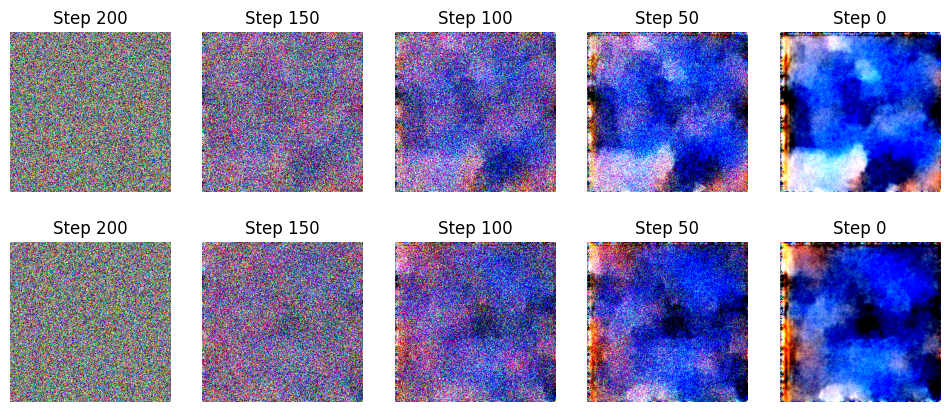

In [132]:
initInput = tf.random.normal((2, *IMAGE_SIZE, 3), dtype=tf.float32)
samples = [initInput]

for t in np.arange(0,T)[::-1]:
    predNoise = model((samples[-1], tf.constant([t,t])))
    xt = samples[-1]
    
    sample, noise = backwardStep(xt, predNoise, t)

    samples.append(sample)

_ = plt.figure(figsize=(12,5))

sampleIdx = np.linspace(0, T, 5)

for j in range(2):
    for i in range(5):
        _ = plt.subplot(2,5,j*5+i+1)
        plt.imshow(np.clip((samples[int(sampleIdx[i])].numpy()[j,:,:,:]+1)/2, 0, 1))
        plt.axis("off")
        plt.title("Step {}".format(T-int(sampleIdx[i])))

In [117]:
testImage=tf.expand_dims(list(dataset.take(50))[34][0],0)
testT=tf.expand_dims(list(dataset.take(50))[34][2],0)
testNoise=tf.expand_dims(list(dataset.take(50))[34][1],0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


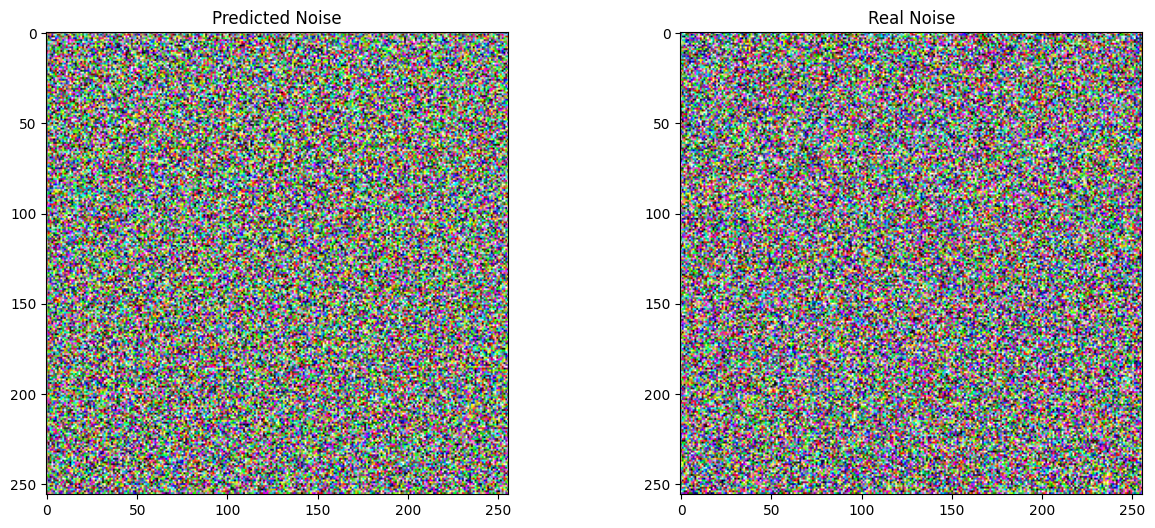

In [118]:
predNoise = model((testImage, testT))
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.imshow((predNoise.numpy()[0,:,:,:]+1)/2)
plt.title("Predicted Noise")
plt.subplot(1,2,2)
plt.title("Real Noise")
plt.imshow((testNoise.numpy()[0,:,:,:]+1)/2)

In [119]:
testTNum = testT.numpy()[0][0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


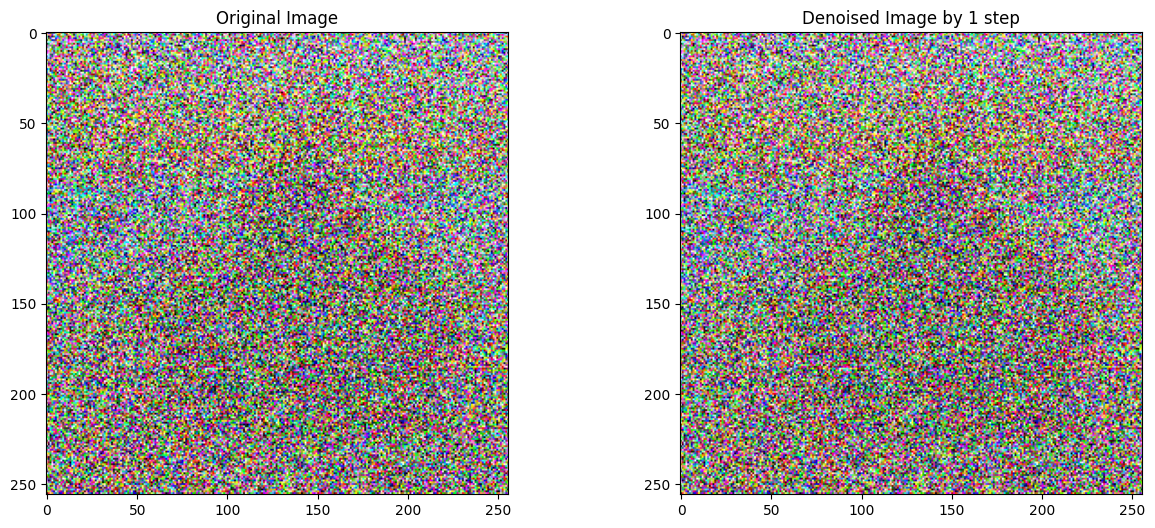

In [120]:
denoised = (testImage - (1-alpha[testTNum])/np.sqrt(1-alphaBar[testTNum])*predNoise)/np.sqrt(alpha[testTNum])
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.imshow((testImage.numpy()[0,:,:,:]+1)/2)
plt.title("Original Image")
plt.subplot(1,2,2)
plt.title("Denoised Image by 1 step")
plt.imshow((denoised.numpy()[0,:,:,:]+1)/2)